In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_absolute_percentage_error
from pathlib import Path

In [2]:
def create_lags(df, lags_list, target_col='valor'):
    """
    Cria defasagens (lags) para transformar a série temporal em um conjunto de dados de regressão.

    df (DataFrame): O DataFrame original com a série temporal.
    lags_list (list): Lista de defasagens a serem criadas (ex: [1, 52]).
    target_col (str): Nome da coluna alvo (y_t).
    """
    # DataFrame auxiliar para armazenar as features.
    df_features = pd.DataFrame(index=df.index)

    # 1. Variável Alvo (y_t): O valor da série no momento t.
    df_features['y'] = df[target_col].copy()

    # 2. Features de Defasagem (X): Valores da série em momentos passados (y_{t-k}).
    for lag in lags_list:
        # A função shift() move os dados da coluna 'valor' 'lag' posições para baixo,
        # criando uma coluna onde cada linha t contém o valor de t-lag.
        df_features[f'lag_{lag}'] = df[target_col].shift(lag)

    # Remove as linhas iniciais que contêm valores NaN (Not a Number) devido ao shift.
    # Essas são as observações onde não há dados anteriores suficientes para criar as lags.
    df_features.dropna(inplace=True)

    # X é a matriz de features, Y é a variável alvo.
    X = df_features.drop('y', axis=1)
    Y = df_features['y']

    return X, Y

In [3]:
CAMINHO_RAIZ = Path(os.getcwd()).resolve().parent.parent
OUTPUT = CAMINHO_RAIZ / 'out' / 'dengue_pernambuco'
os.makedirs(OUTPUT, exist_ok=True)

dengue_pe = pd.read_excel(CAMINHO_RAIZ / 'data' / 'dengue_pernambuco.xlsx')

In [4]:
dengue_pe['semana'] = pd.to_datetime(dengue_pe['semana'])
dengue_pe.set_index('semana', inplace=True)
dengue_pe.sort_index(inplace=True)

In [6]:
n_obs = len(dengue_pe)
p_train = 0.50
p_val = 0.25
n_train = int(n_obs * p_train)
n_val = int(n_obs * p_val)
n_test = n_obs - n_train - n_val

dengue_train = dengue_pe.iloc[:n_train]
dengue_val = dengue_pe.iloc[n_train: n_train + n_val]
dengue_test = dengue_pe.iloc[n_train + n_val:]

In [7]:
LAG_FEATURES = [1, 52]

# Aplicamos a função para criar o conjunto de dados final (X, Y).
X_full, Y_full = create_lags(dengue_pe, LAG_FEATURES)

# Exibimos as primeiras linhas para verificar as features.
print("Estrutura do Conjunto de Features e Alvo (X e Y):")
print(X_full.head())

Estrutura do Conjunto de Features e Alvo (X e Y):
            lag_1  lag_52
semana                   
2001-01-06   44.0   686.0
2001-01-13  174.0   611.0
2001-01-20  147.0   614.0
2001-01-27  218.0   598.0
2001-02-03  237.0   785.0


In [8]:
train_val_end_date = dengue_val.index.max()
train_end_date = dengue_train.index.max()

# X_train e Y_train: Apenas o conjunto de treinamento original.
X_train = X_full.loc[:train_end_date]
Y_train = Y_full.loc[:train_end_date]

# X_val e Y_val: Apenas o conjunto de validação original.
X_val = X_full.loc[train_end_date:train_val_end_date].iloc[1:] # Usa .iloc[1:] para remover o ponto de corte duplicado
Y_val = Y_full.loc[train_end_date:train_val_end_date].iloc[1:]

# X_test e Y_test: O conjunto de teste.
X_test = X_full.loc[train_val_end_date:].iloc[1:]
Y_test = Y_full.loc[train_val_end_date:].iloc[1:]

# X_train_val e Y_train_val: Combinação dos dados para o grid search.
X_train_val = pd.concat([X_train, X_val])
Y_train_val = pd.concat([Y_train, Y_val])

print(f"\nNúmero de observações (após remoção de NaNs):")
print(f"Treinamento: {len(X_train)} | Validação: {len(X_val)} | Teste: {len(X_test)}")


Número de observações (após remoção de NaNs):
Treinamento: 391 | Validação: 221 | Teste: 223


In [10]:
mape_scorer = make_scorer(mean_absolute_percentage_error, greater_is_better=False)

# Define o espaço de busca para o Random Forest.
param_dist = {
    # n_estimators: Número de árvores na floresta. Mais árvores = melhor precisão, mais lento.
    'n_estimators': [100, 200, 300, 400],
    # max_depth: Profundidade máxima de cada árvore. Controla o overfitting.
    'max_depth': [5, 10, 15, None], # None significa profundidade total.
    # min_samples_leaf: Número mínimo de amostras necessárias em um nó folha.
    'min_samples_leaf': [1, 5, 10],
    # max_features: Número de features a considerar ao buscar a melhor divisão. 'sqrt' é um bom padrão.
    'max_features': ['sqrt']
}

# TimeSeriesSplit: Divide o conjunto de dados em folds de treino/validação, onde o conjunto
# de validação é sempre o mais recente, respeitando a ordem temporal.
tscv = TimeSeriesSplit(n_splits=5)

# RandomizedSearchCV: Realiza a busca aleatória.
# estimator: O modelo a ser usado (RandomForestRegressor).
# param_distributions: O espaço de busca definido acima.
# n_iter: Número de combinações de parâmetros a testar.
# scoring: A métrica usada para avaliar (MAPE negativo, para otimização).
# cv: O método de validação cruzada (TimeSeriesSplit).
# random_state: Para reprodutibilidade.
# verbose: Nível de detalhe da saída.
random_search = RandomizedSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_distributions=param_dist,
    n_iter=20, # Testaremos 20 combinações
    scoring=mape_scorer,
    cv=tscv,
    random_state=42,
    verbose=2,
    n_jobs=-1 # Usa todos os processadores disponíveis.
)

# O método fit() executa a busca no conjunto Treinamento + Validação (X_train_val).
random_search.fit(X_train_val, Y_train_val)

# best_params_ armazena os hiperparâmetros que obtiveram o melhor score (menor MAPE) na validação cruzada.
best_params_ap = random_search.best_params_
best_score_ap = -random_search.best_score_ # Reverte o score para o MAPE positivo.

print("\n--- Modelo AP (Random Forest) Selecionado ---")
print(f"Melhores Parâmetros (Random Search): {best_params_ap}")
print(f"Melhor MAPE na Validação Cruzada: {best_score_ap:.2%}")

Fitting 5 folds for each of 20 candidates, totalling 100 fits

--- Modelo AP (Random Forest) Selecionado ---
Melhores Parâmetros (Random Search): {'n_estimators': 100, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'max_depth': None}
Melhor MAPE na Validação Cruzada: 149.32%


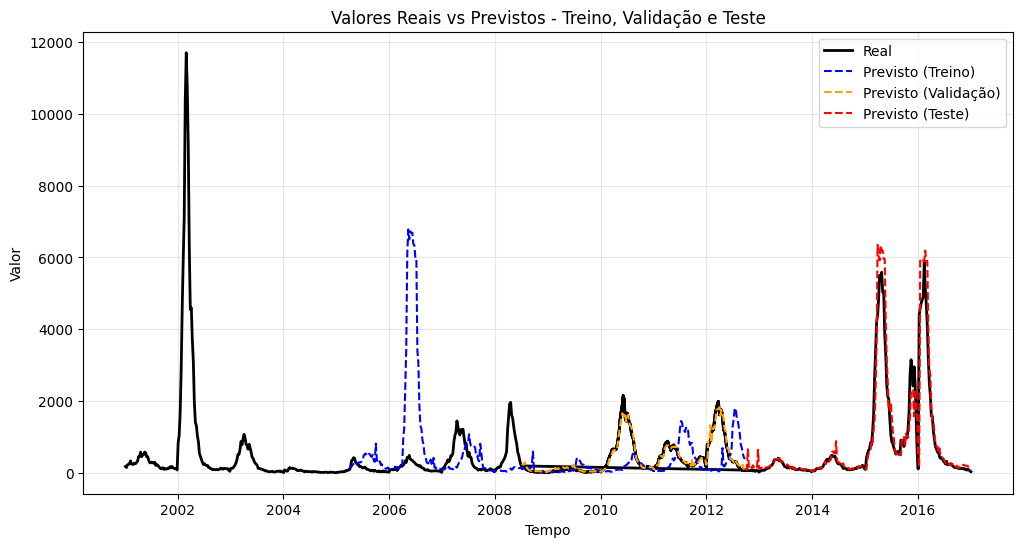

In [36]:
# Instancia o Random Forest com os melhores parâmetros encontrados.
rf_ap_model = RandomForestRegressor(**best_params_ap, random_state=42)

# Treinamento final no conjunto X_train_val.
rf_ap_model.fit(X_train_val, Y_train_val)

# Previsões:
# A função predict() gera as previsões y_hat.
y_pred_train_ap = rf_ap_model.predict(X_train)
y_pred_val_ap = rf_ap_model.predict(X_val)
y_pred_test_ap = rf_ap_model.predict(X_test)

plt.figure(figsize=(12,6))

# Linha real contínua
plt.plot(pd.concat([Y_train_val, Y_val, Y_test]),
         label="Real", color="black", linewidth=2)

# Previsões destacadas por fase
plt.plot(pd.Series(y_pred_train_ap, index=Y_train_val.index[-len(y_pred_train_ap):]),
         label="Previsto (Treino)", color="blue", linestyle="--")

plt.plot(pd.Series(y_pred_val_ap, index=Y_val.index),
         label="Previsto (Validação)", color="orange", linestyle="--")

plt.plot(pd.Series(y_pred_test_ap, index=Y_test.index),
         label="Previsto (Teste)", color="red", linestyle="--")

plt.title("Valores Reais vs Previstos - Treino, Validação e Teste")
plt.xlabel("Tempo")
plt.ylabel("Valor")
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig(OUTPUT / 'random_forest_ap.png')
plt.show()


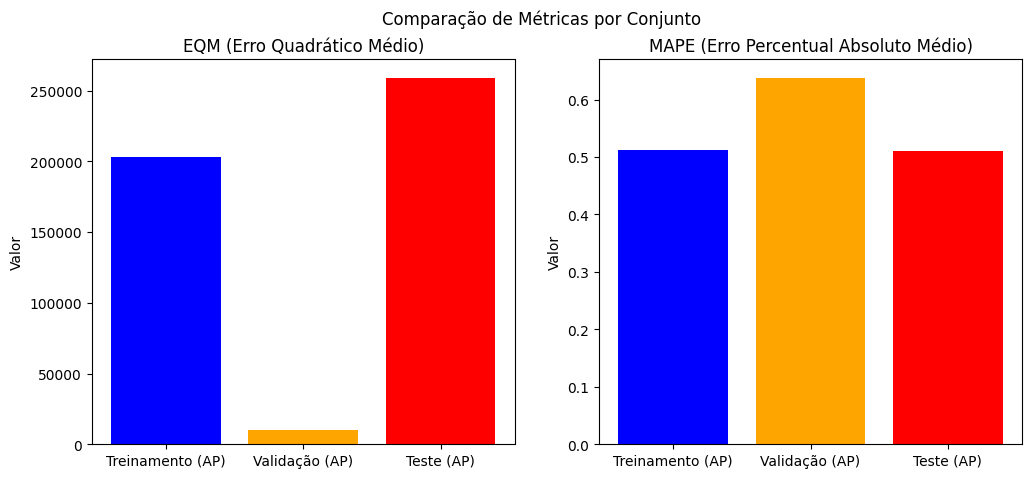

In [38]:
# Métrica de Erro: Cálculo do EQM e MAPE
def evaluate_metrics(y_true, y_pred, name):
    """Calcula e retorna EQM e MAPE para um conjunto específico."""
    mse = mean_squared_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    return {'Conjunto': name, 'EQM': mse, 'MAPE': mape}

results_ap = [
    evaluate_metrics(Y_train, y_pred_train_ap, 'Treinamento (AP)'),
    evaluate_metrics(Y_val, y_pred_val_ap, 'Validação (AP)'),
    evaluate_metrics(Y_test, y_pred_test_ap, 'Teste (AP)')
]
df = pd.DataFrame(results_ap)

# Gráfico de barras lado a lado
fig, ax1 = plt.subplots(1,2, figsize=(12,5))

# EQM
ax1[0].bar(df['Conjunto'], df['EQM'], color=['blue','orange','red'])
ax1[0].set_title("EQM (Erro Quadrático Médio)")
ax1[0].set_ylabel("Valor")

# MAPE
ax1[1].bar(df['Conjunto'], df['MAPE'], color=['blue','orange','red'])
ax1[1].set_title("MAPE (Erro Percentual Absoluto Médio)")
ax1[1].set_ylabel("Valor")

plt.suptitle("Comparação de Métricas por Conjunto")
plt.savefig(OUTPUT / 'random_forest_ap_metrics.png')
plt.show()


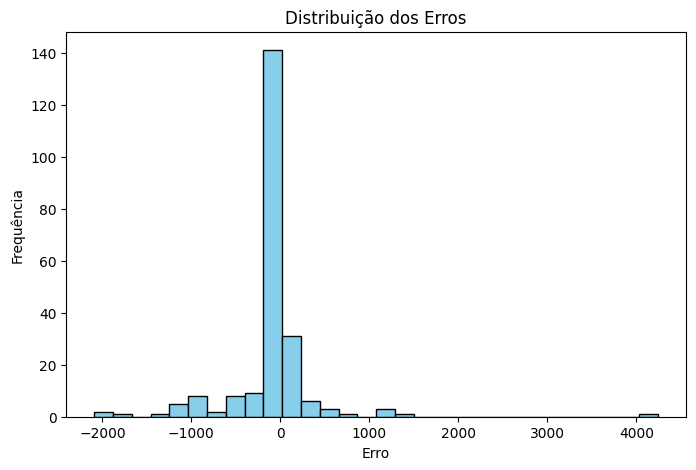

In [41]:
residuos = Y_test - y_pred_test_ap

plt.figure(figsize=(8,5))
plt.hist(residuos, bins=30, color="skyblue", edgecolor="black")
plt.title("Distribuição dos Erros")
plt.xlabel("Erro")
plt.ylabel("Frequência")
plt.savefig(OUTPUT / 'random_forest_ap_residuals.png')
plt.show()